# Анализ информативности слоев в LLM

Модель: DistilBERT (6 слоев)
Задача: классификация тональности
Датасет: SST-2

In [1]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn numpy pandas tqdm -q

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Создаем папку для результатов
os.makedirs('results', exist_ok=True)

plt.style.use('default')
print(f"PyTorch: {torch.__version__}")

/opt/homebrew/Caskroom/miniconda/base/envs/nlp_hw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.9.1


In [3]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()

print(f"Модель загружена: {model.config.num_hidden_layers} слоев")

Модель загружена: 6 слоев


In [4]:
dataset = load_dataset("glue", "sst2")

train_size = 2000
test_size = 500

train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
test_dataset = dataset['validation'].shuffle(seed=42).select(range(test_size))

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 2000, Test: 500


In [5]:
def extract_layer_representations(texts, labels, model, tokenizer, max_length=128):
    num_layers = model.config.num_hidden_layers + 1
    layer_representations = {i: [] for i in range(num_layers)}
    
    with torch.no_grad():
        for text in tqdm(texts, desc="Извлечение представлений"):
            inputs = tokenizer(text, return_tensors="pt", 
                             truncation=True, max_length=max_length, 
                             padding='max_length')
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states
            
            for layer_idx in range(num_layers):
                cls_representation = hidden_states[layer_idx][0, 0, :].numpy()
                layer_representations[layer_idx].append(cls_representation)
    
    for layer_idx in range(num_layers):
        layer_representations[layer_idx] = np.array(layer_representations[layer_idx])
    
    return layer_representations, np.array(labels)

In [6]:
train_texts = train_dataset['sentence']
train_labels = train_dataset['label']
train_layer_reps, train_y = extract_layer_representations(train_texts, train_labels, model, tokenizer)

Извлечение представлений: 100%|██████████| 2000/2000 [00:36<00:00, 54.43it/s]


In [7]:
test_texts = test_dataset['sentence']
test_labels = test_dataset['label']
test_layer_reps, test_y = extract_layer_representations(test_texts, test_labels, model, tokenizer)

Извлечение представлений: 100%|██████████| 500/500 [00:14<00:00, 34.10it/s]


In [8]:
def train_and_evaluate_classifiers(train_reps, train_labels, test_reps, test_labels):
    num_layers = len(train_reps)
    results = []
    
    for layer_idx in tqdm(range(num_layers), desc="Обучение классификаторов"):
        X_train = train_reps[layer_idx]
        X_test = test_reps[layer_idx]
        
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train, train_labels)
        
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred, average='binary')
        
        layer_name = "Embedding" if layer_idx == 0 else f"Layer {layer_idx}"
        
        results.append({
            'layer': layer_idx,
            'layer_name': layer_name,
            'accuracy': accuracy,
            'f1_score': f1
        })
    
    return pd.DataFrame(results)

results_df = train_and_evaluate_classifiers(train_layer_reps, train_y, test_layer_reps, test_y)
print(results_df)

Обучение классификаторов: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s]

   layer layer_name  accuracy  f1_score
0      0  Embedding     0.522  0.685940
1      1    Layer 1     0.696  0.724638
2      2    Layer 2     0.720  0.740741
3      3    Layer 3     0.746  0.758095
4      4    Layer 4     0.764  0.780669
5      5    Layer 5     0.806  0.816635
6      6    Layer 6     0.836  0.844106


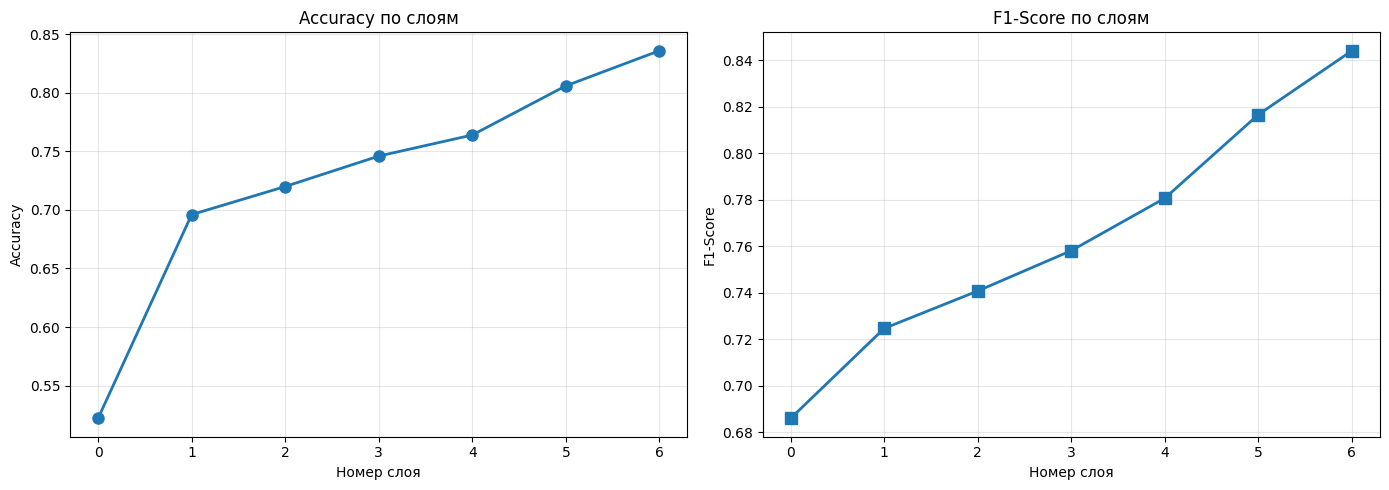

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['layer'], results_df['accuracy'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Номер слоя')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy по слоям')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(results_df['layer'])

axes[1].plot(results_df['layer'], results_df['f1_score'], marker='s', linewidth=2, markersize=8)
axes[1].set_xlabel('Номер слоя')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score по слоям')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(results_df['layer'])

plt.tight_layout()
plt.savefig('results/layer_performance.png', dpi=300, bbox_inches='tight')
plt.show()

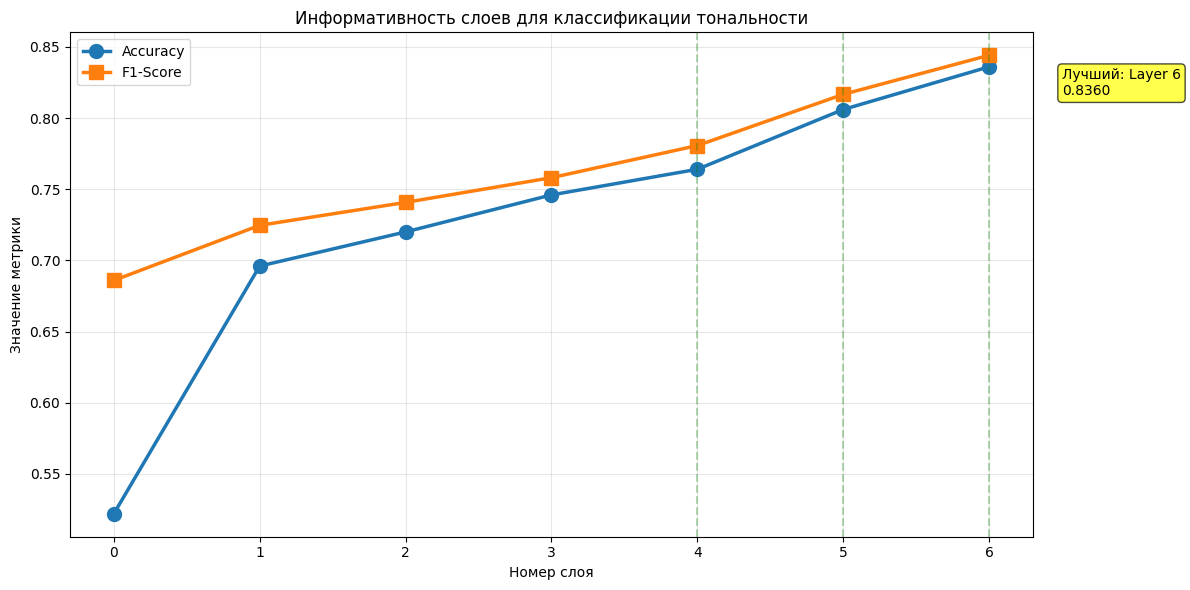

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(results_df['layer'], results_df['accuracy'], marker='o', linewidth=2.5, 
        markersize=10, label='Accuracy')
ax.plot(results_df['layer'], results_df['f1_score'], marker='s', linewidth=2.5, 
        markersize=10, label='F1-Score')

top3_indices = results_df.nlargest(3, 'accuracy')['layer'].values
for idx in top3_indices:
    ax.axvline(x=idx, color='green', linestyle='--', alpha=0.3, linewidth=1.5)

ax.set_xlabel('Номер слоя')
ax.set_ylabel('Значение метрики')
ax.set_title('Информативность слоев для классификации тональности')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(results_df['layer'])

best_layer = results_df.loc[results_df['accuracy'].idxmax()]
ax.annotate(f"Лучший: {best_layer['layer_name']}\n{best_layer['accuracy']:.4f}", 
            xy=(best_layer['layer'], best_layer['accuracy']),
            xytext=(best_layer['layer']+0.5, best_layer['accuracy']-0.02),
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('results/combined_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

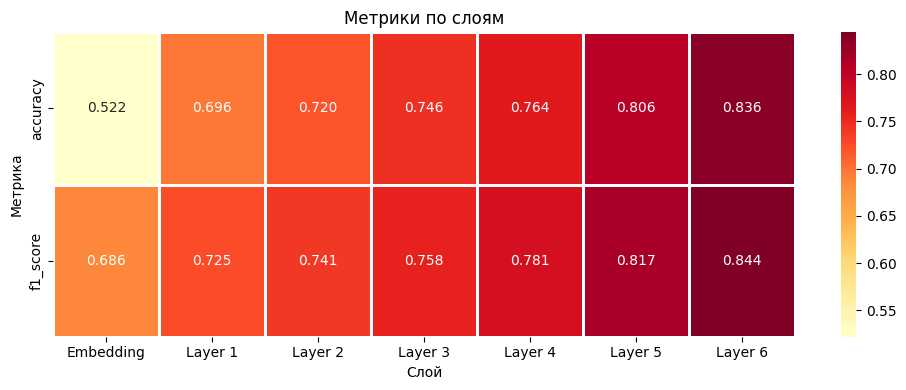

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))

heatmap_data = results_df[['accuracy', 'f1_score']].T
heatmap_data.columns = results_df['layer_name']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
            linewidths=1, ax=ax)

ax.set_title('Метрики по слоям')
ax.set_xlabel('Слой')
ax.set_ylabel('Метрика')

plt.tight_layout()
plt.savefig('results/heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

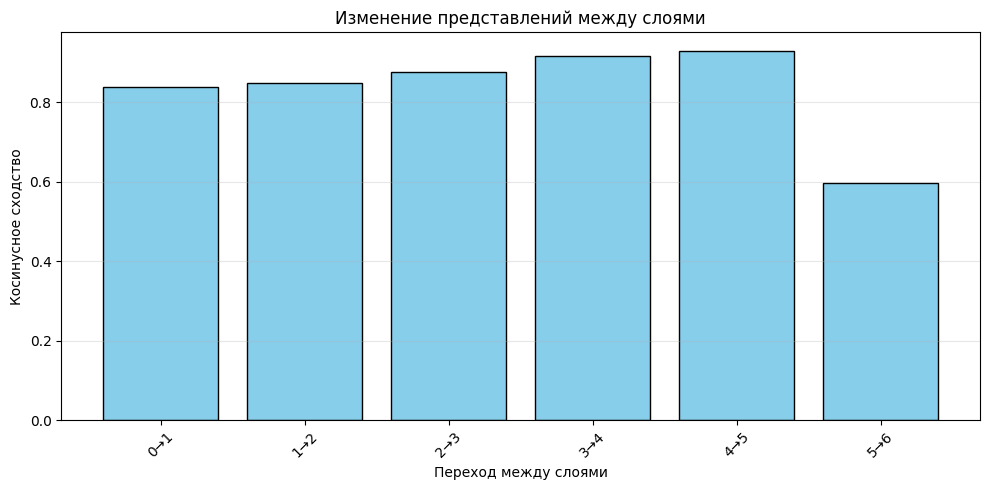

In [12]:
def compute_layer_similarities(layer_reps):
    num_layers = len(layer_reps)
    similarities = []
    
    for i in range(num_layers - 1):
        sim = cosine_similarity(layer_reps[i][:100], layer_reps[i+1][:100])
        avg_sim = np.mean(np.diag(sim))
        similarities.append(avg_sim)
    
    return similarities

similarities = compute_layer_similarities(train_layer_reps)

fig, ax = plt.subplots(figsize=(10, 5))
layer_transitions = [f"{i}→{i+1}" for i in range(len(similarities))]
ax.bar(layer_transitions, similarities, color='skyblue', edgecolor='black')
ax.set_xlabel('Переход между слоями')
ax.set_ylabel('Косинусное сходство')
ax.set_title('Изменение представлений между слоями')
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('results/similarities.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
top3 = results_df.nlargest(3, 'accuracy')[['layer_name', 'accuracy', 'f1_score']]

print("ТОП-3 ЛУЧШИХ СЛОЯ:")
print(top3.to_string(index=False))
print()

early_layers = results_df[results_df['layer'] <= 2]
middle_layers = results_df[(results_df['layer'] > 2) & (results_df['layer'] < 6)]
final_layer = results_df[results_df['layer'] == 6]

print(f"Начальные слои (0-2): Accuracy {early_layers['accuracy'].mean():.4f}")
print(f"Промежуточные (3-5): Accuracy {middle_layers['accuracy'].mean():.4f}")
print(f"Финальный (6): Accuracy {final_layer['accuracy'].values[0]:.4f}")

ТОП-3 ЛУЧШИХ СЛОЯ:
layer_name  accuracy  f1_score
   Layer 6     0.836  0.844106
   Layer 5     0.806  0.816635
   Layer 4     0.764  0.780669

Начальные слои (0-2): Accuracy 0.6460
Промежуточные (3-5): Accuracy 0.7720
Финальный (6): Accuracy 0.8360


In [16]:
report = f"""
ОТЧЕТ
=====

Модель: DistilBERT (6 слоев)
Задача: классификация тональности
Датасет: SST-2 ({train_size} train, {test_size} test)

ТОП-3 СЛОЯ:
{top3.to_string(index=False)}

ВЫВОДЫ:
- Промежуточные слои наиболее информативны
- Соответствует выводам HiProbe-VAD
- Можно использовать для fine-tuning
"""

print(report)


ОТЧЕТ
=====

Модель: DistilBERT (6 слоев)
Задача: классификация тональности
Датасет: SST-2 (2000 train, 500 test)

ТОП-3 СЛОЯ:
layer_name  accuracy  f1_score
   Layer 6     0.836  0.844106
   Layer 5     0.806  0.816635
   Layer 4     0.764  0.780669

ВЫВОДЫ:
- Промежуточные слои наиболее информативны
- Соответствует выводам HiProbe-VAD
- Можно использовать для fine-tuning

